In [2]:
import numpy as np
import matplotlib.pyplot as plt
from Serpy import compute_directional_stats, compute_df, fit_ellipses, ellipse_params_to_maps, corrected_orientation, retrieval_Algorithm
import fabio
import tifffile


In [7]:
ref = fabio.open('/Users/samy/Desktop/PhD/Random_Code/Repo/SerPy/data/Hexagonal_modulator/Carbon_tubes_ref_800mm_0_00003_img.edf').data
sample = fabio.open('/Users/samy/Desktop/PhD/Random_Code/Repo/SerPy/data/Hexagonal_modulator/Carbon_tubes_sample_800mm_0_00002_img.edf').data

In [8]:
angles = np.linspace(0, 2*np.pi, 15, endpoint=False)
results = retrieval_Algorithm(ref=ref[:, :],
                              img=sample[:, :],
                              angles=angles,
                              window_size=3,
                              band_thickness=1,
                              step=1,
                              smooth_sigma=9.0,
                              return_intermediates=True,
                              strict_finite=True,
                              verbose=True)

[dfr_pipeline_checked] HxW=(1028, 512),
 angles=given,
 win=3, thick=1, step=1,
 sigma=9.0, strict_finite=True

Starting DF Retrieval pipeline...
Using 15 angles for directional statistics.


Computing directional stats: 100%|██████████| 15/15 [00:41<00:00,  2.77s/angle]


Computed directional statistics for sample image.


Computing directional stats: 100%|██████████| 15/15 [00:42<00:00,  2.83s/angle]


Computed directional statistics for reference image.
Computed directional, non-directional dark-field and transmission maps.
Fitted ellipses to directional dark-field profiles.
Corrected orientation map and computed saturation map.
Computed derived maps: eccentricity, intensity, area.


In [9]:
for key, value in results.items():
    print(f"{key}: {value.shape}")

angles: (15,)
Non-oriented Df: (1028, 512)
Oriented Df: (1028, 512, 15)
T: (1028, 512)
major axis: (1028, 512)
minor axis: (1028, 512)
Orientation: (1028, 512)
Corrected Orientation: (1028, 512)
saturation: (1028, 512)
eccentricity: (1028, 512)
intensity: (1028, 512)
area: (1028, 512)
mean_s: (1028, 512, 16)
std_s: (1028, 512, 16)
mean_r: (1028, 512, 16)
std_r: (1028, 512, 16)


In [10]:
major = results['major axis']
minor = results['minor axis']

fabio.edfimage.EdfImage(data=major).write("/Users/samy/Desktop/major_axis.edf")
fabio.edfimage.EdfImage(data=minor).write("/Users/samy/Desktop/minor_axis.edf")
# # Clean up small negative values due to numerical errors and set the very small values to zero to avoid the insane of backgroud noise
minor[minor < 0.09] = 0
major[minor == 0] = 0

eccentricity = np.sqrt(1 - (minor**2 / major**2))
intensity = np.sqrt(major**2 + minor**2)
eccentricity = np.nan_to_num(eccentricity)
intensity = np.nan_to_num(intensity)

/var/folders/0_/k993vz617nqfl4vy722j5c8c0000gn/T/ipykernel_9907/4084786504.py:10: RuntimeWarning: invalid value encountered in divide
  eccentricity = np.sqrt(1 - (minor**2 / major**2))


/Users/samy/miniconda3/envs/FinalEnvs/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 119955 (\N{MATHEMATICAL BOLD ITALIC SMALL R}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


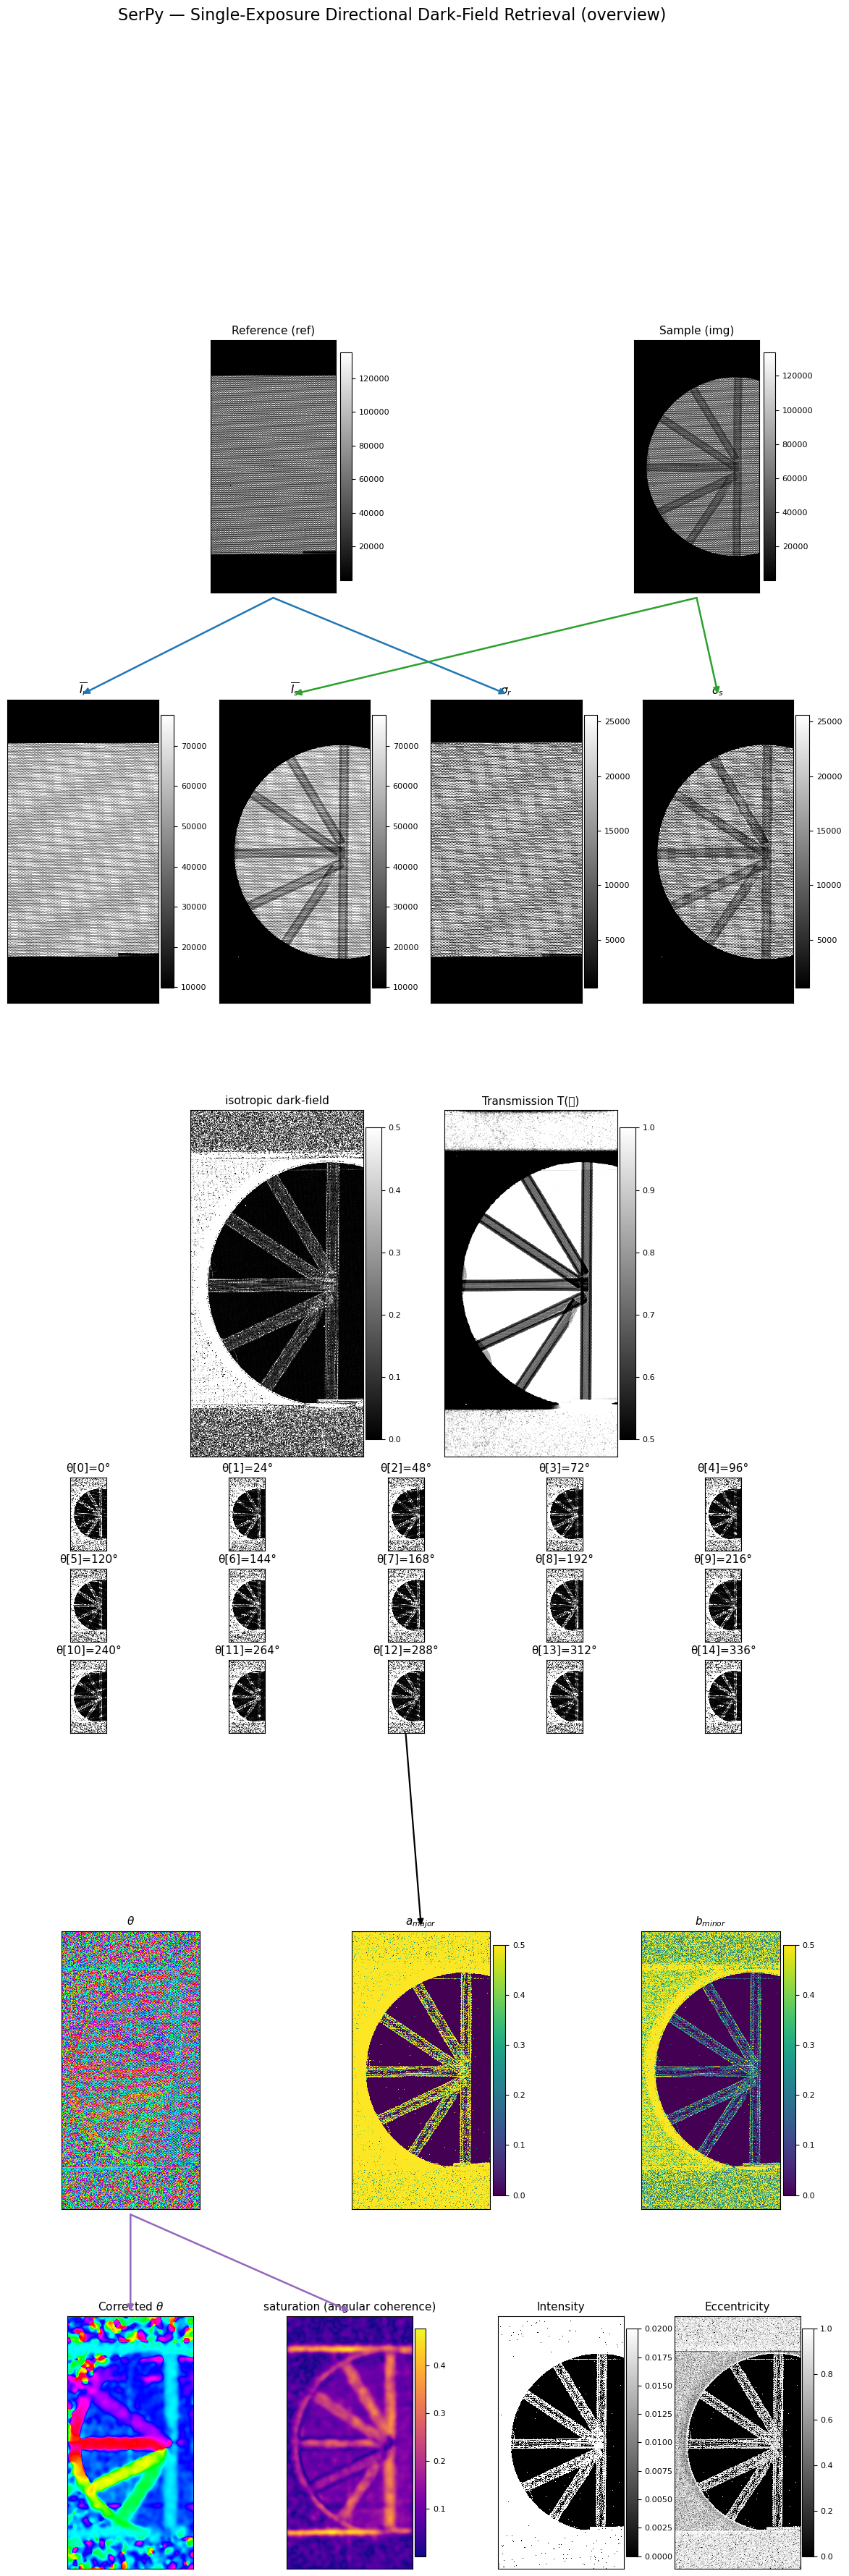

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import ConnectionPatch
from matplotlib.colors import hsv_to_rgb

# ------------------------------------------------------------
# Helpers
# ------------------------------------------------------------
def _imshow(ax, img, title="", cmap="gray", vmin=None, vmax=None):
    im = ax.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax, interpolation="nearest")
    ax.set_title(title, fontsize=11)
    ax.set_xticks([]); ax.set_yticks([])
    return im

def _add_colorbar(fig, ax, mappable, shrink=0.9, pad=0.01):
    cbar = fig.colorbar(mappable, ax=ax, shrink=shrink, pad=pad)
    cbar.ax.tick_params(labelsize=8)
    return cbar

def _arrow(fig, ax_from, ax_to, color="k", lw=1.8, connectionstyle="arc3,rad=0.0"):
    """Arrow between centers of two axes (ax_from -> ax_to)."""
    xyA = (0.5, -0.02)  # bottom center of ax_from
    xyB = (0.5,  1.02)  # top center of ax_to
    con = ConnectionPatch(
        xyA=xyA, coordsA=ax_from.transAxes,
        xyB=xyB, coordsB=ax_to.transAxes,
        arrowstyle="-|>", shrinkA=0, shrinkB=0,
        mutation_scale=12, lw=lw, color=color,
        connectionstyle=connectionstyle
    )
    fig.add_artist(con)

def orientation_to_rgb(theta, magnitude=None, clip_mag=True):
    """Encode θ (rad) -> RGB via HSV: hue = θ mod π (axial symmetry)."""
    H = (np.mod(theta, np.pi)) / np.pi
    if magnitude is None:
        S = np.ones_like(H, dtype=float)
    else:
        S = np.asarray(magnitude, dtype=float)
        if clip_mag:
            S = (S - np.nanmin(S)) / (np.nanmax(S) - np.nanmin(S) + 1e-12)
    V = np.ones_like(H, dtype=float)
    return hsv_to_rgb(np.stack([H, S, V], axis=-1))

# ------------------------------------------------------------
# Main plotting function (updated layout)
# ------------------------------------------------------------
def plot_serpy_figure(sample, ref, out, mean_idx=7, oriented_cmap="magma"):
    """
    Layout:
      Row 1: [REF | SAMPLE]
      Row 2: [mean_r | mean_s | std_r | std_s] (with arrows from REF/SAMPLE)
      Row 3: [Non-oriented Df] (alone on its own line)
      Row 4: 15 thumbnails of Oriented Df (on a separate line)
      Row 5: [Orientation (HSV) | major axis | minor axis] (arrows from Oriented/Non-oriented)
      Row 6: [Corrected Orientation | saturation] (arrows from Orientation only)
    """
    # --- Unpack ---
    angles     = out["angles"]                    # (A,)
    df_iso     = out["Non-oriented Df"]           # (H,W)
    df_dir     = out["Oriented Df"]               # (H,W,A)
    T          = out.get("T", None)               # (H,W) optional display here
    a_major    = out["major axis"]                # (H,W)
    a_minor    = out["minor axis"]                # (H,W)
    theta_raw  = out["Orientation"]               # (H,W)
    theta_corr = out["Corrected Orientation"]     # (H,W)
    sat        = out["saturation"]                # (H,W)
    mean_s     = out.get("mean_s", None)          # (H,W,16)
    std_s      = out.get("std_s", None)           # (H,W,16)
    mean_r     = out.get("mean_r", None)          # (H,W,16)
    std_r      = out.get("std_r", None)           # (H,W,16)
    theta_raw  += np.pi / 2  # Adjust orientation by 90°
    theta_corr += np.pi / 2
    theta_raw  %=  np.pi
    theta_corr %=  np.pi
    H, W = df_iso.shape
    A    = angles.shape[0]

    if mean_s is not None:
        mean_idx = int(np.clip(mean_idx, 0, mean_s.shape[-1]-1))

    vmin_ref, vmax_ref = np.percentile(ref,    [1, 99])
    vmin_sam, vmax_sam = np.percentile(sample, [1, 99])

    # --- Figure + GridSpec (now 6 rows) ---
    fig = plt.figure(figsize=(15, 40))
    gs = GridSpec(
        nrows=6, ncols=20, figure=fig,
        height_ratios=[1.0, 1.2, 1.0, 1.4, 1.1, 1.0],
        hspace=0.38, wspace=0.15
    )

    # Row 1: REF | SAMPLE
    ax_ref    = fig.add_subplot(gs[0, 0:10])
    ax_sample = fig.add_subplot(gs[0, 10:20])
    im_ref    = _imshow(ax_ref, ref, title="Reference (ref)", cmap="gray", vmin=vmin_ref, vmax=vmax_ref)
    _add_colorbar(fig, ax_ref, im_ref)
    im_sam    = _imshow(ax_sample, sample, title="Sample (img)", cmap="gray", vmin=vmin_sam, vmax=vmax_sam)
    _add_colorbar(fig, ax_sample, im_sam)

    # Row 2: mean/std (r,s)
    ax_mean_r = fig.add_subplot(gs[1, 0:5])
    ax_mean_s = fig.add_subplot(gs[1, 5:10])
    ax_std_r  = fig.add_subplot(gs[1, 10:15])
    ax_std_s  = fig.add_subplot(gs[1, 15:20])

    if mean_r is not None:
        im_mr = _imshow(ax_mean_r, mean_r[..., mean_idx], title=rf"$\overline{{I_r}}$", vmin=np.mean(mean_r)-np.std(mean_r), vmax=np.mean(mean_r)+np.std(mean_r))
        _add_colorbar(fig, ax_mean_r, im_mr)
    else:
        _imshow(ax_mean_r, np.zeros((H, W)), title="mean_r (missing)")

    if mean_s is not None:
        im_ms = _imshow(ax_mean_s, mean_s[..., mean_idx], title=rf"$\overline{{I_s}}$", vmin=np.mean(mean_r)-np.std(mean_r), vmax=np.mean(mean_r)+np.std(mean_r))
        _add_colorbar(fig, ax_mean_s, im_ms)
    else:
        _imshow(ax_mean_s, np.zeros((H, W)), title="mean_s (missing)")

    if std_r is not None:
        im_sr = _imshow(ax_std_r, std_r[..., mean_idx], title=rf"$\sigma_r$", vmin=np.mean(std_r)-np.std(std_r), vmax=np.mean(std_r)+np.std(std_r))
        _add_colorbar(fig, ax_std_r, im_sr)
    else:
        _imshow(ax_std_r, np.zeros((H, W)), title="std_r (missing)")

    if std_s is not None:
        im_ss = _imshow(ax_std_s, std_s[..., mean_idx], title=rf"$\sigma_s$", vmin=np.mean(std_r)-np.std(std_r), vmax=np.mean(std_r)+np.std(std_r))
        _add_colorbar(fig, ax_std_s, im_ss)
    else:
        _imshow(ax_std_s, np.zeros((H, W)), title="std_s (missing)")

    # Arrows from REF -> mean_r, std_r ; SAMPLE -> mean_s, std_s
    _arrow(fig, ax_ref,    ax_mean_r, color="tab:blue")
    _arrow(fig, ax_ref,    ax_std_r,  color="tab:blue")
    _arrow(fig, ax_sample, ax_mean_s, color="tab:green")
    _arrow(fig, ax_sample, ax_std_s,  color="tab:green")


    from matplotlib.gridspec import GridSpecFromSubplotSpec

    # === Sous-grille compacte pour rows 3–4 ===
    sub = GridSpecFromSubplotSpec(
        2, 20, subplot_spec=gs[2:4, 0:20], hspace=0.06, wspace=0.15 
    )

    # --- Row 3 : Non-oriented Df + Transmission ---
    ax_iso = fig.add_subplot(sub[0, 4:10])
    im_iso = _imshow(ax_iso, df_iso, title="isotropic dark-field", cmap="gray", vmin=0, vmax=0.5)
    _add_colorbar(fig, ax_iso, im_iso)

    ax_T = fig.add_subplot(sub[0, 10:16])
    im_T = _imshow(ax_T, T, title="Transmission T(𝒓)", cmap="gray", vmin=0.5, vmax=1)
    _add_colorbar(fig, ax_T, im_T)

    # --- Row 4 : Oriented Df thumbnails (15 images) ---
    oriented_axes = []
    oriented_grid = GridSpecFromSubplotSpec(
        4, 5, subplot_spec=sub[1, 1:19], hspace=0.25, wspace=0.3  # centré, compact
    )

    for i in range(A):  # A == 15
        r, c = divmod(i, 5)                 # (0..2, 0..4)
        ax = fig.add_subplot(oriented_grid[r, c])
        im = _imshow(ax, df_dir[..., i],
                    title=f"θ[{i}]={np.rad2deg(angles[i]):.0f}°",
                    cmap='gray', vmin=0, vmax=0.5)
        oriented_axes.append(ax)

    
    
    
    # # Row 3: Non-oriented Df (left) + Transmission (right)
    # ax_iso = fig.add_subplot(gs[2, 4:10])
    # im_iso = _imshow(ax_iso, df_iso, title="Non-oriented Df (isotropic dark-field)", cmap="gray",vmin=0,vmax=0.5)
    # _add_colorbar(fig, ax_iso, im_iso)

    # ax_T = fig.add_subplot(gs[2, 10:16])
    # im_T = _imshow(ax_T, T, title="Transmission T(𝒓)", cmap="gray",vmin = 0.5, vmax=1)
    # _add_colorbar(fig, ax_T, im_T)

    # # Arrows from Row 2 (center) to isotropic DF
    # _arrow(fig, ax_mean_s, ax_iso, color="k", lw=1.6)
    # _arrow(fig, ax_std_r,  ax_iso, color="k", lw=1.0, connectionstyle="arc3,rad=0.1")

    # # Row 4: Oriented Df thumbnails (15) on a separate line
    # oriented_axes = []
    # # Use columns 0..19 -> 20 slots; we need 15 thumbnails => give each ~1 col, leave small margins
    # start_col = 2
    # for i in range(A):
    #     ax = fig.add_subplot(gs[3, start_col + i : start_col + i + 1])
    #     im = _imshow(ax, df_dir[..., i], title=f"θ[{i}]={np.rad2deg(angles[i]):.0f}°", cmap='gray', vmin=0, vmax=0.5)
    #     oriented_axes.append(ax)

    # Arrow from Non-oriented Df down to the middle oriented thumbnail row
    mid_ax = oriented_axes[12]


    # Row 5: Orientation (HSV) | major axis | minor axis
    ax_orient = fig.add_subplot(gs[4, 0:7])
    orient_rgb = orientation_to_rgb(theta_raw, magnitude=None)
    ax_orient.imshow(orient_rgb, interpolation="nearest")
    ax_orient.set_title(rf"$\theta$", fontsize=11)
    ax_orient.set_xticks([]); ax_orient.set_yticks([])

    ax_major = fig.add_subplot(gs[4, 7:13])
    im_M = _imshow(ax_major, a_major, title=rf"$a_{{major}}$", cmap="viridis",vmin =0, vmax=0.5)
    _add_colorbar(fig, ax_major, im_M)

    ax_minor = fig.add_subplot(gs[4, 13:20])
    im_m = _imshow(ax_minor, a_minor, title=rf"$b_{{minor}}$", cmap="viridis",vmin =0, vmax=0.5)
    _add_colorbar(fig, ax_minor, im_m)
    _arrow(fig, mid_ax, ax_major, color="k", lw=1.6)
    # Arrows from oriented thumbnails & iso DF to row 5
    # _arrow(fig, mid_ax,  ax_orient, color="k")
    # _arrow(fig, ax_iso,  ax_major,  color="k")
    # _arrow(fig, ax_iso,  ax_minor,  color="k")

    # Row 6: Corrected Orientation | saturation (from Orientation only)
    ax_orient_corr = fig.add_subplot(gs[5, 1:6])
    orient_corr_rgb = orientation_to_rgb(theta_corr, magnitude=None)
    ax_orient_corr.imshow(orient_corr_rgb, interpolation="nearest")
    ax_orient_corr.set_title(rf"Corrected $\theta$", fontsize=11)
    ax_orient_corr.set_xticks([]); ax_orient_corr.set_yticks([])

    ax_saturation = fig.add_subplot(gs[5, 6:11])
    im_sat = _imshow(ax_saturation, sat, title="saturation (angular coherence)", cmap="plasma")
    _add_colorbar(fig, ax_saturation, im_sat)

    ax_intensity = fig.add_subplot(gs[5, 11:16])
    im_int = _imshow(ax_intensity, intensity, title="Intensity", cmap="gray", vmin= 0, vmax = 0.02)
    _add_colorbar(fig, ax_intensity, im_int)
    
    ax_eccentricity = fig.add_subplot(gs[5, 16:20])
    im_ecc = _imshow(ax_eccentricity, eccentricity, title="Eccentricity", cmap="gray", vmin=0, vmax=1)
    _add_colorbar(fig, ax_eccentricity, im_ecc)
    
    
    _arrow(fig, ax_orient, ax_orient_corr, color="tab:purple")
    _arrow(fig, ax_orient, ax_saturation,  color="tab:purple")

    fig.suptitle("SerPy — Single-Exposure Directional Dark-Field Retrieval (overview)", fontsize=16, y=0.995)
    plt.show()
    
plot_serpy_figure(sample, ref, results, mean_idx=7)

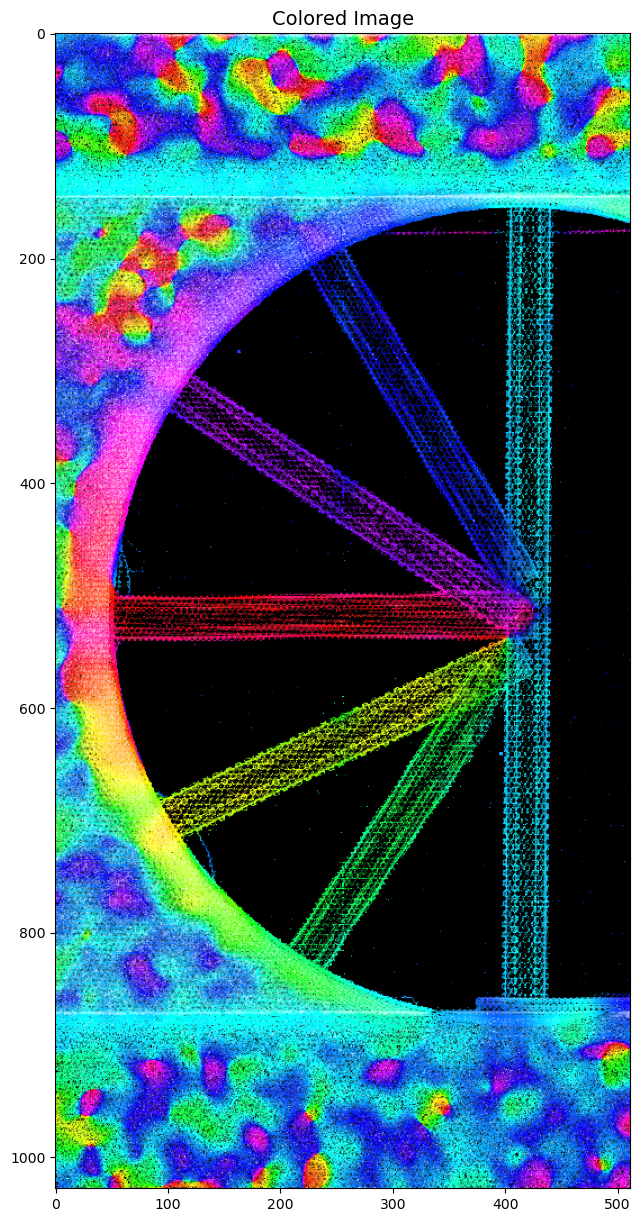

In [12]:
# intensity_ = (intensity - 0) / ( - 0 + 1e-12)
intensity_ = np.clip(intensity, 0, 1)
# eccentricity_ = (eccentricity - np.min(eccentricity)) / (np.max(eccentricity) - np.min(eccentricity) + 1e-12)
stack_colored = np.stack([results["Corrected Orientation"]/np.pi,
                          eccentricity,
                          intensity_], axis=-1)


colored_image = hsv_to_rgb(stack_colored)

plt.figure(figsize=(15,15))
plt.imshow(colored_image, cmap="hsv", vmin=0, vmax=np.pi)
plt.title("Colored Image", fontsize=14)

plt.show()